# Instagram Open Profile Scraping
<p style='text-align: justify;'>
This notebook will scrape somone's profile using his/her username. The main data to be collected are profile informations and post's details, with the media (image) itself. For example, i'm using Samuel Chan's Instagram Profile (@officialsamuel) 
    
</p>

# Dependencies

### Selenium
Selenium is a package to automate interaction trough your browser. You can install selenium using 
`
pip install selenium
`
or
`
conda install -c conda-forge selenium
`
Depending on what source you want to install from.

In [1]:
import selenium
print(selenium.__version__)

3.141.0


### Chrome Web Driver
Web driver is tool that provides the capabilites of controlling the browser automatically. I'm using `Google Chrome`, so I decided to use `ChromeDriver` that you can download from http://chromedriver.chromium.org/. And make sure you save it on accessable path

Please mind the compatibilities within `ChromeDriver` and `Google Chrome`. I'm currently using Chrome ver. 77.0.3865.75 and ChromeDriver ver. 77.0.3865.40

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go

import re
import requests
import time
import warnings

from bs4 import BeautifulSoup as bs
from datetime import date
from pandas.io.json import json_normalize
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from selenium import webdriver
from tqdm import tqdm
from urllib.request import urlopen

%matplotlib inline
warnings.filterwarnings("ignore", module="matplotlib")

init_notebook_mode(connected=True)

# Web Scraping

## Open the browser 

In [3]:
# constants
# username='iqbalbasyar'
username='officialsamuel'
# username = 'iraseugin'
# username = 'teamalgoritma'

chrome_driver_path = 'chromedriver.exe'
browser = webdriver.Chrome(chrome_driver_path)
browser.get('https://www.instagram.com/'+username)

## Get the profile information

In [4]:
page = urlopen('https://www.instagram.com/'+username).read()
data = bs(page, 'html.parser')
body = data.find('body')
script = body.find('script')
raw = script.text.strip().replace('window._sharedData =', '').replace(';', '')
json_data = json.loads(raw)

In [5]:
profile = json_data['entry_data']['ProfilePage'][0]['graphql']
# profile

In [6]:
p_name = profile['user']['full_name']
p_username = profile['user']['username']
p_follower = profile['user']['edge_followed_by']['count']
p_follow = profile['user']['edge_follow']['count']
p_n_post = profile['user']['edge_owner_to_timeline_media']['count']
_data = {'username':p_username, 'name':p_name, 'follower':p_follower, 'following':p_follow, 'post':p_n_post}
df_profile = pd.DataFrame(data=_data, index=['username'])
df_profile


,username,name,follower,following,post
username,officialsamuel,Samuel,339,84,49


## Get the media (post) informations

In [15]:
max_post = 200 #depends on how many post you want to scrape
max_post = min(max_post, df_profile['post'].values[0])
max_post

49

### 1. Collect all the link by scrolling

In [16]:
links = set()
browser.execute_script('window.scrollTo(0, 0)')
while len(links) < max_post:
    prev_len = len(links)
    source = browser.page_source
    data=bs(source, 'html.parser')
    body = data.find('body')
    script = body.find('span')
    for link in script.findAll('a'):
        if re.match("/p", link.get('href')):
            links.add('https://www.instagram.com'+link.get('href'))
    if len(links) != prev_len : print('Collected Post : {}/{}'.format(len(links), max_post))
    browser.execute_script('window.scrollTo(0, document.body.scrollHeight)')
    page_load = browser.execute_script('return document.readyState')
    while page_load != 'complete':
        page_load = browser.execute_script('return document.readyState')
        time.sleep(2)
    

Collected Post : 24/49
Collected Post : 36/49
Collected Post : 48/49
Collected Post : 49/49


### 2. Access the media 
Scrape several informations about the posts. I want to get several information: 
- Post ID
- Number of likes
- Number of comments
- Timestamp
- The display image

In [17]:
result=pd.DataFrame()
for link in tqdm(links):
    try:
        page = urlopen(link).read()
        data=bs(page, 'html.parser')
        body = data.find('body')
        script = body.find('script')
        raw = script.text.strip().replace('window._sharedData =', '').replace(';', '')
        json_data=json.loads(raw)
        posts =json_data['entry_data']['PostPage'][0]['graphql']
        posts= json.dumps(posts)
        posts = json.loads(posts)
        x = pd.DataFrame.from_dict(json_normalize(posts), orient='columns') 
        x.columns =  x.columns.str.replace("shortcode_media.", "")
        result=result.append(x)
       
    except:
        np.nan
    

  4%|███▍                                                                               | 2/49 [00:00<00:19,  2.39it/s]C:\Users\dzul\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.91it/s]


In [19]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 0
Data columns (total 57 columns):
__typename                                              49 non-null object
accessibility_caption                                   42 non-null object
caption_is_edited                                       49 non-null bool
comments_disabled                                       49 non-null bool
dimensions.height                                       49 non-null int64
dimensions.width                                        49 non-null int64
display_resources                                       49 non-null object
display_url                                             49 non-null object
edge_media_preview_comment.count                        44 non-null float64
edge_media_preview_comment.edges                        44 non-null object
edge_media_preview_like.count                           49 non-null int64
edge_media_preview_like.edges                           49 non-null object
edge

Not all of the columns are useful(yet), so I selected only some of them

In [20]:
# sort by chronological order
result = result.sort_values(by='taken_at_timestamp')

In [21]:
post_id = result['shortcode']
# post_id

In [22]:
post_likes = result['edge_media_preview_like.count']
# post_likes

In [23]:
post_comments = result['edge_media_to_parent_comment.count']
post_comments = post_comments.fillna(0.0)
# post_comments

In [24]:
post_timestamp = result['taken_at_timestamp']
post_timestamp = post_timestamp.apply(date.fromtimestamp)
# post_timestamp

In [25]:
if 'location.name' in result.columns:
    post_location = result['location.name']
    post_location.fillna("None", inplace=True)
else:
    post_location = pd.Series(data=['None']*len(result))
# post_location

Cons : 
- The location name seems unstructured. Thus, we cannot easily make  heatmap using map based on its location

In [26]:
_data = {'id' : post_id, 'timestamp' : post_timestamp, 'likes' : post_likes, 'comments' : post_comments, 'location':post_location}
df_post = pd.DataFrame(data=_data)

In [28]:
df_post.head(10)

,id,timestamp,likes,comments,location
0,8tI3_enxaK,2015-10-12,6,1.0,None
0,80wpktHxUq,2015-10-14,7,2.0,None
0,BQZOIIbjg_O,2017-02-12,18,0.0,None
0,BQajkYDj6oN,2017-02-12,16,2.0,None
0,BQdX3cOjgcX,2017-02-13,13,2.0,Vườn nho ba mọi Ninh Thuận
0,BQedKjAD-GK,2017-02-14,20,0.0,Cổng Trời Chùa Linh Quy Pháp Ấn Lâm Đồng
0,BQfpvF6Dn1-,2017-02-14,12,1.0,Vườn nho ba mọi Ninh Thuận
0,BQhn47NjJmK,2017-02-15,25,1.0,Phan Rang
0,BQnIUk0hHZO,2017-02-17,14,0.0,None
0,BRIOrFtBx2b,2017-03-02,48,0.0,None


## 3. Download the media (image)
<p style='text-align: justify;'>
Save the structured data (df_profile.csv and df_post.csv) and download all the display image for each post. I assume all the media are image and the post are not multi-image type
</p>

In [ ]:
try:
    os.mkdir(p_username)
except OSError as e:
    pass

download_path = p_username+'/'

for i in tqdm(range(len(result))):
    r = requests.get(result['display_url'][i])
    with open(download_path+result['shortcode'][i]+".jpg", 'wb') as f:
                    f.write(r.content)

In [30]:
export_csv = df_profile.to_csv (p_username+'/profile.csv', index = None , header=True) 
export_csv = df_post.to_csv (p_username+'/post.csv', index = None , header=True) 

# Exploration

I want to know : 
- most frequent places
- most commented post
- most liked post

- interval between post (predict when to post again) to know is he a scheduled person or not

todo:
- know the characteristic of the posts with image classification

### Load the scraped file

In [50]:
df_profile = pd.read_csv(p_username+'/profile.csv')
df_profile

,username,name,follower,following,post
0,officialsamuel,Samuel,339,84,49


In [70]:
df_post = pd.read_csv(p_username+'/post.csv')
df_post.head()

,id,likes,comments,location
timestamp,,,,
2015-10-12,8tI3_enxaK,6,1.0,None
2015-10-14,80wpktHxUq,7,2.0,None
2017-02-12,BQZOIIbjg_O,18,0.0,None
2017-02-12,BQajkYDj6oN,16,2.0,None
2017-02-13,BQdX3cOjgcX,13,2.0,Vườn nho ba mọi Ninh Thuận


### Most Frequent Places
Counting the most tagged places in post

In [133]:
top5_place = df_post['location'][df_post['location'] != 'None'].value_counts()[:5]
top5_place

Algoritma                     3
Danau Kaolin, Belitung        3
Marina Bay Sands              2
Vườn nho ba mọi Ninh Thuận    2
HUBBA Thailand                2
Name: location, dtype: int64

In [304]:
fig = go.Figure([go.Bar(
    y = top5_place, 
    x = top5_place.index,
    )])
fig.show()

# iplot(fig, filename='top5place.html')

notes : I wanted the bins to be stack of the image for each places (I can't do this yet).

### Most Commented Post

In [128]:
top5_comment = df_post.sort_values(by = ['comments'], ascending=False).head(5)
top5_comment

,id,likes,comments,location
timestamp,,,,
2019-07-26,B0YzT1HnVIo,26,5.0,None
2019-02-15,Bt58Wt8gHs_,77,5.0,"Bali, Indonesia"
2017-03-30,BSP9BhqBYcF,36,5.0,"Gantung, Belitung Timur"
2019-01-22,Bs7w871nKk7,41,4.0,HUBBA Thailand
2018-03-17,Bgbm9sclIxx,50,4.0,Belitung Island


In [170]:
img = []
for i in top5_comment['id']:
    img.append(mpimg.imread(df_profile['username'][0]+'/'+i+'.jpg'))

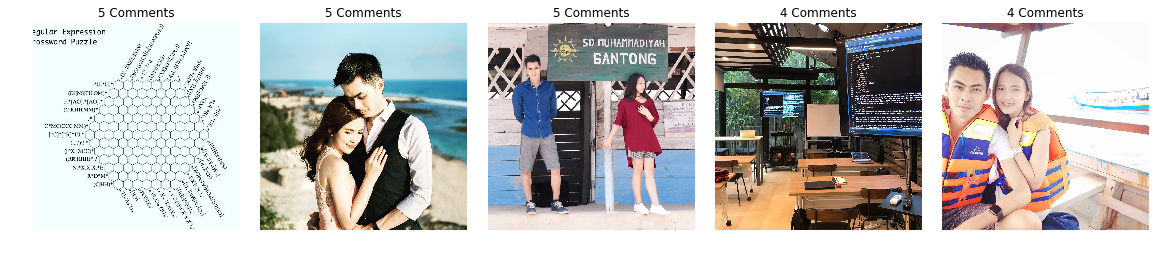

In [228]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(len(img)):
        ax[i].imshow(img[i])
        ax[i].set_title(str(int(top5_comment['comments'][i]))+' Comments')
        ax[i].axis('off')
plt.show()

### Most Liked Post

In [229]:
top5_like = df_post.sort_values(by = ['likes'], ascending=False).head(5)
top5_like

,id,likes,comments,location
timestamp,,,,
2019-03-04,BulRtszg1Rx,85,2.0,None
2019-02-15,Bt58Wt8gHs_,77,5.0,"Bali, Indonesia"
2019-04-11,BwG7_Hig4dg,56,0.0,Algoritma
2019-02-13,Bt05wNRADtn,54,1.0,IOI City Mall
2017-07-06,BWNJqWGBUR4,50,3.0,None


In [230]:
img = []
for i in top5_like['id']:
    img.append(mpimg.imread(df_profile['username'][0]+'/'+i+'.jpg'))

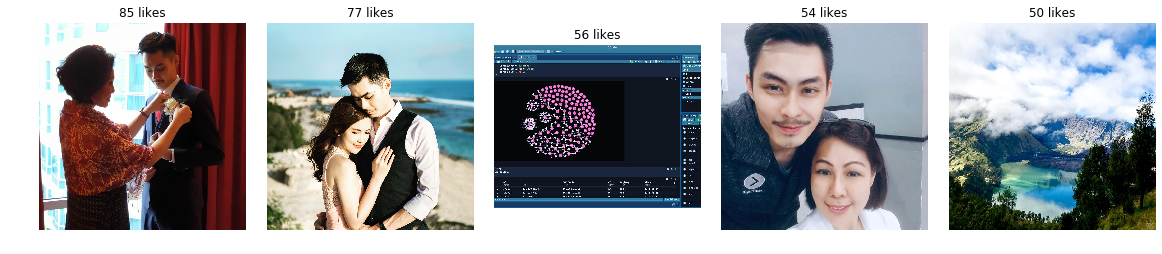

In [231]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(len(img)):
        ax[i].imshow(img[i])
        ax[i].set_title(str(top5_like['likes'][i])+' likes')
        ax[i].axis('off')
plt.show()

### Post activity
I wanted to know the expected interval between each post

In [232]:
df_post.index = pd.to_datetime(df_post.index)

In [233]:
set1 = df_post.index[:-1]
set2 = df_post.index[1:]
post_interval = set2- set1

In [234]:
pd.Series(post_interval).mean()

Timedelta('28 days 19:30:00')

In [289]:
min(post_interval)

Timedelta('0 days 00:00:00')

In [290]:
max(post_interval)

Timedelta('487 days 00:00:00')

### Post Activity Map

In [235]:
import calmap

In [236]:
time_range = pd.date_range(start=df_post.index[0], end=df_post.index[-1])
days = df_post.index
events = pd.Series(np.ones(len(days)), index=days)

(<Figure size 864x720 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000252D8CD8BE0>,
       dtype=object))

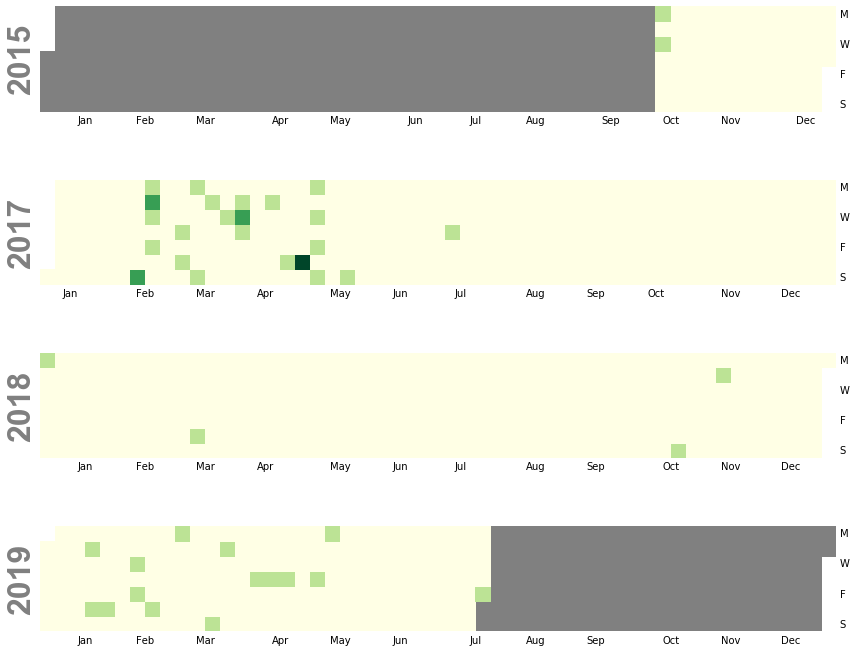

In [237]:
calmap.calendarplot(events, monthticks=1, daylabels='MTWTFSS',
                    dayticks=[0,2,4,6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(12, 10)))

<p style='text-align: justify;'> Based on the heatmap above, it's clear that Sam don't post often. The biggest space are in between 2nd half of 2015 to the early 2017. <b>Sam's off for half a year</b> , based on the data, at least (assuming there's no deleted posts) </p>

### Likes, comments, and follower

In [247]:
avg_like = df_post['likes'].mean()
avg_comment = df_post['comments'].mean()
follower = df_profile['follower'][0]

In [262]:
avg_like, avg_comment, follower

(30.224489795918366, 1.183673469387755, 339)

In [286]:
colors = [ 'gray', 'lightslategray', 'crimson']

fig = go.Figure(data=[go.Bar(
    x=['average like', 'average comments', 'followers'],
    y=[avg_like, avg_comment, follower],
    marker_color=colors 
)])
fig.update_layout()

In [294]:
random_x = df_post.index
random_y0 = df_post['likes']
random_y1 = df_post['comments']

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines+markers',
                    name='Likes'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines+markers',
                    name='Comments'))
fig.show()

<p style='text-align: justify;'> The bar plot shows that there's a gap betwen Sam's current follower and his post's average likes or comments. It's supported by the second plot (line plot)that tells his viewer's activity only occurs below the number of 100</p>

# Conclusion

We only use several data but there are more data to collects, and more insight to be found.

There are several thing that I might want to do in the future
- collect all the comment for each post and do sentiment analysis for each post
- classify the image into several classes and do content profiling and segmentation